# Advanced Neural Networks: Deep Learning For Spatial Analysis

# Case Study #2 — Semantic Segmentation in Autonomous Driving

# Rhichard Koh

In [ ]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import shutil
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import segmentation_models_pytorch as smp
import torchvision.transforms.functional as TF

# Checking Image and Mask

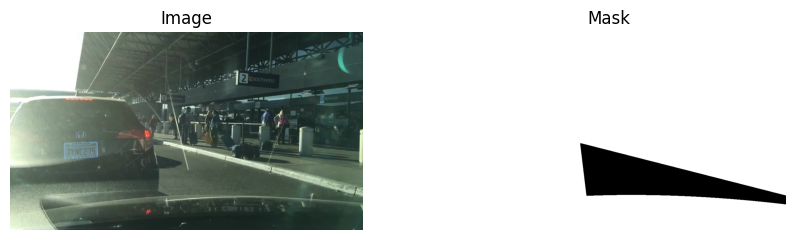

In [ ]:
# Example paths to an image and a mask
sample_image_path = "100k_images_train/bdd100k/images/100k/train/0a0a0b1a-27d9fc44.jpg"
sample_mask_path = "bdd100k_drivable_labels_trainval/bdd100k/labels/drivable/masks/train/0a0a0b1a-27d9fc44.png"

# Load image and mask
image = Image.open(sample_image_path)
mask = Image.open(sample_mask_path)

# Plot image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.show()


# Collecting the Image-Mask Pair

In [2]:
images_dir = "100k_images_train/bdd100k/images/100k/train"
masks_dir = "bdd100k_drivable_labels_trainval/bdd100k/labels/drivable/masks/train"

In [ ]:
image_mask_pair = []

# Function to collect image-mask pairs
def collect_image_mask_pairs(images_dir, masks_dir):
    # List all JPEG image files in the images directory
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith('.jpg')]
    pairs = []
    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        base_name = os.path.splitext(img_file)[0]
        # Assuming mask files have the same base name with a .png extension
        mask_filename = base_name + '.png'
        mask_path = os.path.join(masks_dir, mask_filename)
        
        # Check if the corresponding mask file exists
        if os.path.exists(mask_path):
            pairs.append((img_path, mask_path))
        else:
            print(f"Warning: No mask found for image: {img_file}")
    
    return pairs

image_mask_pair = collect_image_mask_pairs(images_dir, masks_dir)


In [4]:
len(image_mask_pair)

60892

# Shuffling the Pairs for Randomization

In [ ]:
random.seed(42)
random.shuffle(image_mask_pair)

# Getting a subset of the whole dataset

In [6]:
train_size = 10000
val_size = 1000
test_size = 1000

train_pairs = image_mask_pair[:train_size]
val_pairs = image_mask_pair[train_size:train_size + val_size]
test_pairs = image_mask_pair[train_size + val_size:train_size + val_size + test_size]

print(f"train size: {len(train_pairs)}")
print(f"val_size: {len(val_pairs)}")
print(f"test_size: {len(test_pairs)}")

train size: 10000
val_size: 1000
test_size: 1000


In [ ]:
# Base directories for subsets
base_data_dir = 'data_subset'
base_masks_dir = 'labels_subset/masks'

# Paths for each subset
subset_train_images_dir = os.path.join(base_data_dir, 'train')
subset_train_masks_dir = os.path.join(base_masks_dir, 'train')

subset_val_images_dir = os.path.join(base_data_dir, 'val')
subset_val_masks_dir = os.path.join(base_masks_dir, 'val')

subset_test_images_dir = os.path.join(base_data_dir, 'test')
subset_test_masks_dir = os.path.join(base_masks_dir, 'test')

# Create directories if they don't exist
os.makedirs(subset_train_images_dir, exist_ok=True)
os.makedirs(subset_train_masks_dir, exist_ok=True)
os.makedirs(subset_val_images_dir, exist_ok=True)
os.makedirs(subset_val_masks_dir, exist_ok=True)
os.makedirs(subset_test_images_dir, exist_ok=True)
os.makedirs(subset_test_masks_dir, exist_ok=True)


In [ ]:
# Function to copy files to a destination directory
def copy_files(pairs, images_dir, masks_dir):
    for img_path, mask_path in pairs:
        # Copy image
        dst_img_path = os.path.join(images_dir, os.path.basename(img_path))
        shutil.copy(img_path, dst_img_path)

        # Copy mask
        dst_mask_path = os.path.join(masks_dir, os.path.basename(mask_path))
        shutil.copy(mask_path, dst_mask_path)

# Copy training files
copy_files(train_pairs, subset_train_images_dir, subset_train_masks_dir)

# Copy validation files
copy_files(val_pairs, subset_val_images_dir, subset_val_masks_dir)

# Copy test files
copy_files(test_pairs, subset_test_images_dir, subset_test_masks_dir)


# Calculating which classes have the most representation

In [ ]:
# load mask data for checking class imbalance
def load_masks(mask_folder):
    mask_files = [os.path.join(mask_folder, file) for file in os.listdir(mask_folder) if file.endswith('.png')]
    masks = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in mask_files]
    return masks

mask_folder = 'labels_subset/masks/train'
check_masks_class_imbalance = load_masks(mask_folder)


# function to calulate the class frequencies
def calculate_class_frequencies(masks):
    unique, counts = np.unique(np.concatenate(masks, axis=None), return_counts=True)
    frequency_dict = dict(zip(unique, counts))
    total_pixels = sum(counts)
    class_frequencies = {k: v / total_pixels for k, v in frequency_dict.items()}
    return class_frequencies

class_frequencies = calculate_class_frequencies(check_masks_class_imbalance)
print("Class Frequencies:", class_frequencies)

Class Frequencies: {0: 0.11966413552517362, 1: 0.04868801095920139, 2: 0.831647853515625}


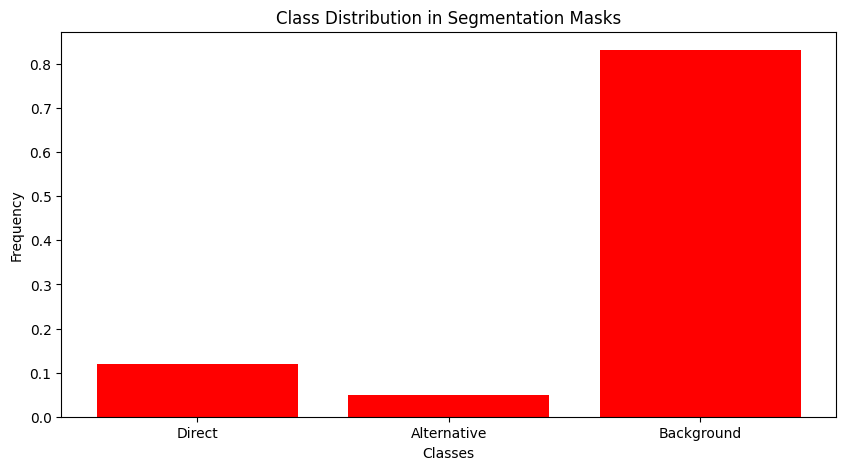

In [ ]:
class_labels = {0: 'Direct', 1: 'Alternative', 2: 'Background'}


def plot_class_distribution(class_frequencies, class_labels):
    # Extract classes and frequencies
    classes = list(class_frequencies.keys())
    frequencies = list(class_frequencies.values())
    
    # Map numeric classes to string labels
    labels = [class_labels[cls] for cls in classes]

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.bar(labels, frequencies, color='red')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title('Class Distribution in Segmentation Masks')
    plt.xticks(labels)
    plt.show()

plot_class_distribution(class_frequencies, class_labels)

The background class is significantly overrepresented in the dataset, which could lead to a bias in the model's predictions toward this class. To address this, I will employ a technique that calculates the weights for each class inversely proportional to their frequencies in the dataset. By using these weights in the loss function, the model will assign higher penalties to misclassifications of underrepresented classes and lower penalties to the overrepresented ones. This weighted loss approach ensures a more balanced learning process, helping the model to better handle class imbalances and improving its ability to generalize across all classes.

# Normalizing the weights of the 3 classes

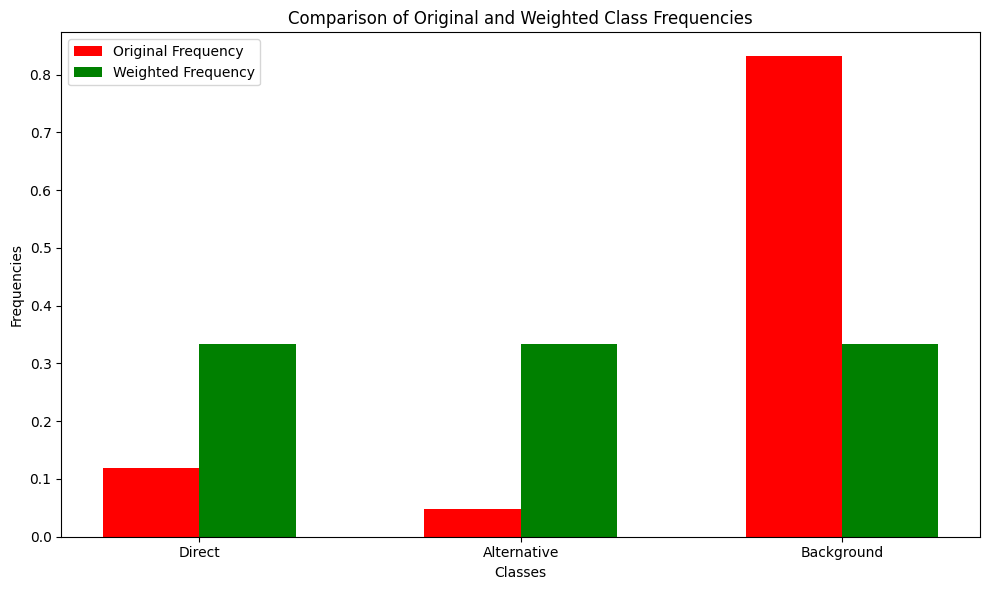

In [ ]:
def calculate_and_plot_class_weights(class_labels, class_frequencies):
    # Convert to numpy array if not already
    class_frequencies = np.array(class_frequencies)

    # Calculate weights inversely proportional to frequencies
    weights = 1 / class_frequencies

    # Normalize weights for comparison
    normalized_weights = weights / weights.sum()

    # Calculate weighted frequencies
    weighted_frequencies = class_frequencies * weights
    weighted_frequencies /= weighted_frequencies.sum()  # Normalize

    # Plot
    x = np.arange(len(class_labels))  # Indices for bar positions
    plt.figure(figsize=(10, 6))

    # Original frequencies
    plt.bar(x - 0.15, class_frequencies, width=0.3, label='Original Frequency', color='red', align='center')

    # Weighted frequencies
    plt.bar(x + 0.15, weighted_frequencies, width=0.3, label='Weighted Frequency', color='green', align='center')

    # Adding labels and titles
    plt.xlabel('Classes')
    plt.ylabel('Frequencies')
    plt.title('Comparison of Original and Weighted Class Frequencies')
    plt.xticks(x, class_labels)  # Set class labels as x-axis labels
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

class_labels = ['Direct', 'Alternative', 'Background']
calculate_and_plot_class_weights(class_labels, np.array(list(class_frequencies.values())))


In [ ]:
# Using GPU device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate weights inversely proportional to class frequencies
weights = np.array([1 / freq if freq > 0 else 0 for freq in list(class_frequencies.values())])

# Normalize weights to ensure they sum to the number of classes
weights /= weights.sum()
weights *= len(class_frequencies)

# Convert weights to a PyTorch tensor
weights = torch.tensor(weights, dtype=torch.float32)

# Move the weights to the device
weights = weights.to(device)

# Print weights for verification
print(f"Weights on {device}: {weights}")


Weights on cuda: tensor([0.8329, 2.0472, 0.1199], device='cuda:0')


# Preparing the subset dataset to be fitted into our model

In [ ]:
# Define the Dataset class
class BDD100KDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=(736, 1280)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize to consistent dimensions
        image = cv2.resize(image, self.image_size[::-1])  # Reverse to (width, height)
        mask = cv2.resize(mask, self.image_size[::-1], interpolation=cv2.INTER_NEAREST)

        # Normalize the image to [0, 1] and convert to tensor
        image = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1)  # Shape: [C, H, W]
        mask = torch.tensor(mask, dtype=torch.long)  # Shape: [H, W]
        
        return image, mask

# Directories for dataset
train_image_dir = "data_subset/train"
train_mask_dir = "labels_subset/masks/train"
val_image_dir = "data_subset/val"
val_mask_dir = "labels_subset/masks/val"
test_image_dir = "data_subset/test"
test_mask_dir = "labels_subset/masks/test"

train_dataset = BDD100KDataset(train_image_dir, train_mask_dir)
val_dataset = BDD100KDataset(val_image_dir, val_mask_dir)
test_dataset = BDD100KDataset(test_image_dir, test_mask_dir)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Defining the model and training

I chose to use a LinkNet model due to its computational efficiency, which makes it an excellent choice for tasks requiring real-time or resource-constrained processing. LinkNet's encoder-decoder architecture, designed with simplicity and minimal overhead, ensures fast inference times while maintaining high accuracy. Its lightweight design allows it to perform well on devices with limited computational power, such as embedded systems or GPUs with modest capabilities. This balance between performance and efficiency makes LinkNet an ideal solution for scenarios where quick and reliable segmentation is critical without the need for excessive computational resources.

In [ ]:
# Initialize the model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



model = smp.Linknet(
    encoder_name='resnet34',       # Encoder: ResNet34
    encoder_weights='imagenet',   # Use ImageNet pre-trained weights
    in_channels=3,                # RGB input
    classes=3                      # Number of output classes (3 in this case)
).to(device)


criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

# Validation Loop
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
    
    return total_loss / len(loader)

# EarlyStopping and ReduceLROnPlateau Parameters
patience = 5  # Number of epochs with no improvement for EarlyStopping
lr_patience = 5  # Number of epochs with no improvement for ReduceLROnPlateau
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
factor = 0.5  # Factor by which learning rate will be reduced
min_lr = 1e-6  # Minimum learning rate for ReduceLROnPlateau

# Variables to track progress
best_val_loss = np.inf
early_stop_counter = 0
train_history = []
val_history = []

# Scheduler for learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=lr_patience, min_lr=min_lr, verbose=True)

# Training and validation loop
num_epochs = 100  # Adjust as needed
for epoch in range(num_epochs):
    # Training
    train_loss = train(model, train_loader, optimizer, criterion, device)
    
    # Validation
    val_loss = validate(model, val_loader, criterion, device)
    
    # Append losses
    train_history.append(train_loss)
    val_history.append(val_loss)

    # Save the best model
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_drivable_segmentation_model.pth")
        early_stop_counter = 0  # Reset counter if improvement
        print(f"Epoch {epoch+1}: New best model saved!")
    else:
        early_stop_counter += 1

    # Reduce learning rate if validation loss plateaus
    scheduler.step(val_loss)

    # Print epoch details
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Check for early stopping
    if early_stop_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

# Save the final model
torch.save(model.state_dict(), "drivable_segmentation_model.pth")


c:\Users\xxryk\OneDrive\Desktop\Durham College\4th Year 1st Semester\Advanced Neural Networks Deep Learning For Spatial Analysis\Case Study #2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


c:\Users\xxryk\OneDrive\Desktop\Durham College\4th Year 1st Semester\Advanced Neural Networks Deep Learning For Spatial Analysis\Case Study #2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: New best model saved!
Epoch 1/100, Train Loss: 0.5732, Val Loss: 0.4649
Epoch 2: New best model saved!
Epoch 2/100, Train Loss: 0.3989, Val Loss: 0.3928
Epoch 3: New best model saved!
Epoch 3/100, Train Loss: 0.3545, Val Loss: 0.3301
Epoch 4: New best model saved!
Epoch 4/100, Train Loss: 0.3248, Val Loss: 0.3184
Epoch 5: New best model saved!
Epoch 5/100, Train Loss: 0.3023, Val Loss: 0.3161
Epoch 6: New best model saved!
Epoch 6/100, Train Loss: 0.2819, Val Loss: 0.3084
Epoch 7/100, Train Loss: 0.2672, Val Loss: 0.3215
Epoch 8: New best model saved!
Epoch 8/100, Train Loss: 0.2503, Val Loss: 0.2985
Epoch 9: New best model saved!
Epoch 9/100, Train Loss: 0.2353, Val Loss: 0.2870
Epoch 10/100, Train Loss: 0.2141, Val Loss: 0.2881
Epoch 11/100, Train Loss: 0.2040, Val Loss: 0.2980
Epoch 12/100, Train Loss: 0.1830, Val Loss: 0.2904
Epoch 13/100, Train Loss: 0.1740, Val Loss: 0.3240
Epoch 14/100, Train Loss: 0.1582, Val Loss: 0.3245
Early stopping triggered. Training stopped.


# Plotting the Train vs Val Loss

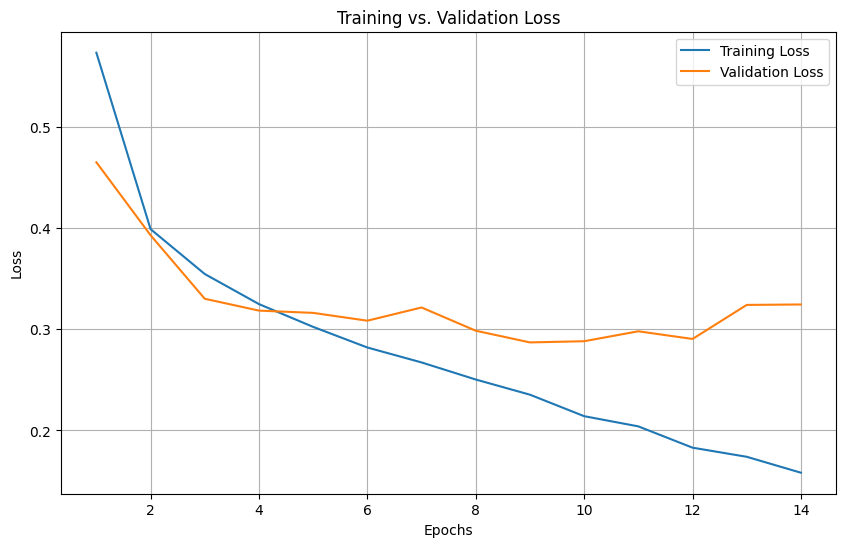

Plot saved as train_val Loss plot.png


In [26]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_history) + 1), train_history, label='Training Loss')
plt.plot(range(1, len(train_history) + 1), val_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid()

# Save the plot as an image
plot_path = "train_val Loss plot.png"
plt.savefig(plot_path)  # Save the plot
plt.show()

print(f"Plot saved as {plot_path}")

# Visualizing the test dataset

In [ ]:
# Function to display images, ground truth masks, and predictions
def visualize_samples(model, dataset, device, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 12))
    random_indices = random.sample(range(len(dataset)), num_samples)


    for idx,i in enumerate(random_indices):
        image, mask = dataset[i]
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(device)
            output = model(image_tensor)
            predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        # Convert image and mask to displayable formats
        image_np = TF.to_pil_image(image.cpu())
        mask_np = mask.numpy()
        
        # Plot image
        axes[idx, 0].imshow(image_np)
        axes[idx, 0].set_title("Input Image")
        axes[idx, 0].axis("off")

        # Plot ground truth mask
        axes[idx, 1].imshow(mask_np, cmap='gray')
        axes[idx, 1].set_title("Ground Truth Mask")
        axes[idx, 1].axis("off")

        # Plot predicted mask
        axes[idx, 2].imshow(predicted_mask, cmap='gray')
        axes[idx, 2].set_title("Predicted Mask")
        axes[idx, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

C:\Users\xxryk\AppData\Local\Temp\ipykernel_28456\1158594740.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_drivable_segmentatio

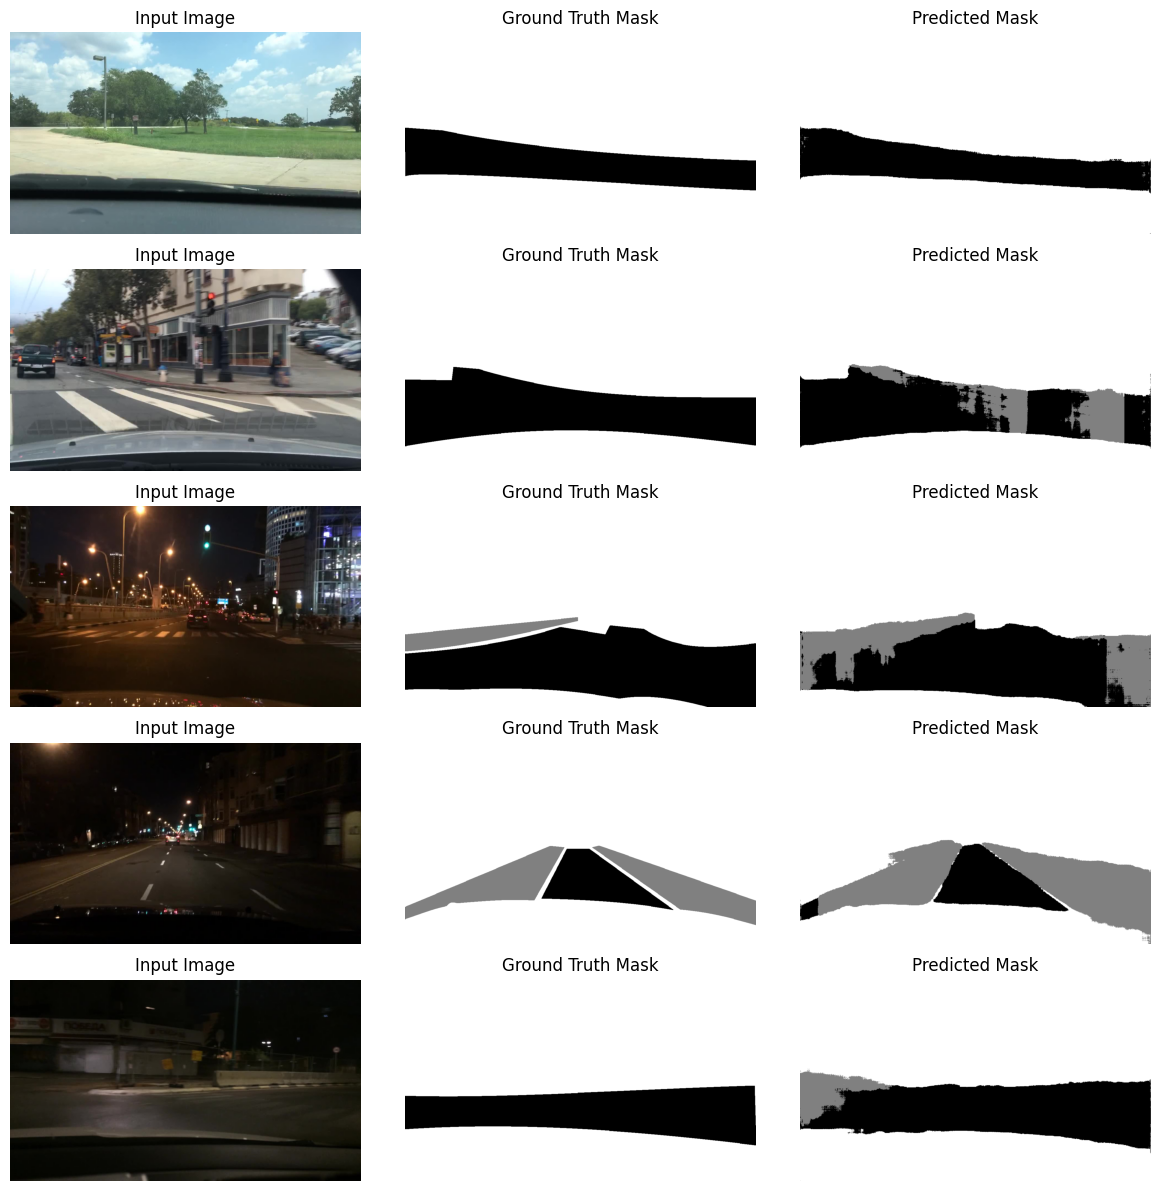

In [ ]:
# Visualize samples
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = smp.Linknet(
    encoder_name='resnet34',       # Encoder: ResNet34
    encoder_weights='imagenet',   # Use ImageNet pre-trained weights
    in_channels=3,                # RGB input
    classes=3                      # Number of output classes (3 in this case)
).to(device)

model.load_state_dict(torch.load("best_drivable_segmentation_model.pth"))

visualize_samples(model, test_dataset, device, num_samples=5)

# Computing the IOU of our model

In [ ]:
def compute_iou(pred_mask, true_mask, num_classes):
    """
    Calculate IoU for each class and return the mean IoU across classes.
    """
    iou_per_class = []
    for cls in range(num_classes):
        pred_class = (pred_mask == cls)
        true_class = (true_mask == cls)
        intersection = (pred_class & true_class).sum()
        union = (pred_class | true_class).sum()
        if union == 0:
            iou_per_class.append(float('nan'))  # Ignore if no pixels for this class
        else:
            iou_per_class.append(intersection / union)
    return np.nanmean(iou_per_class)

def IOU(model, dataset, device, num_classes=3):
    """
    Compute the mean IoU for the model on the given dataset.
    """
    model.eval()
    iou_scores = []
    for i in range(len(dataset)):
        image, mask = dataset[i]
        mask = mask.numpy()  # Convert the ground truth mask to numpy
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(device)
            output = model(image_tensor)
            predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
            mean_iou = compute_iou(predicted_mask, mask, num_classes)
            iou_scores.append(mean_iou)  # Append the IoU score for the current sample
    
    # Compute the dataset's mean IoU, ignoring NaN values
    dataset_mean_iou = np.nanmean(iou_scores)
    return dataset_mean_iou

# Usage example
dataset_mean_iou = IOU(model, test_dataset, device)
print(f"Test Mean IoU: {dataset_mean_iou:.4f}")

Test Mean IoU: 0.6285


My best model achieved a training loss of 0.2503 and a validation loss of 0.2985, indicating a well-generalized performance with minimal overfitting. On the test dataset, the model attained an Intersection over Union (IoU) score of 0.6285, demonstrating its effectiveness in accurately segmenting regions of interest. The training process was early stopped at the 14th epoch after observing no significant improvement in validation loss for a patience of 5 epochs. This early stopping mechanism helped prevent overfitting and ensured optimal model performance while maintaining computational efficiency. These results highlight the robustness and stability of the model during training and evaluation.